In [30]:

import keras
from keras.utils import to_categorical
from keras.utils import load_img, img_to_array
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten,Conv2D, BatchNormalization,Activation,MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam,SGD,RMSprop
import os

In [32]:
import opendatasets as od

In [34]:
dataset = "https://www.kaggle.com/datasets/msambare/fer2013"

In [36]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import networkx as nx


In [38]:
def create_adjacency_matrix(image, num_nodes=64):
    h, w = image.shape[:2]
    points = np.random.rand(num_nodes, 2)
    points[:, 0] *= w
    points[:, 1] *= h
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    
    # Connect each point to its k nearest neighbors
    k = 5
    for i, point in enumerate(points):
        distances = [np.linalg.norm(point - other_point) for other_point in points]
        nearest = np.argsort(distances)[1:k+1]  # Exclude self
        for j in nearest:
            G.add_edge(i, j)
    
    return nx.adjacency_matrix(G).toarray()

In [40]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224), color_mode="rgb")
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = preprocess_image(image)
        features.append(img)
    return np.array(features)

In [42]:
def prepare_graph_data(images):
    adjacency_matrices = []
    for image in tqdm(images):
        img = preprocess_image(image)
        adj_matrix = create_adjacency_matrix(img)
        adjacency_matrices.append(adj_matrix)
    return np.array(adjacency_matrices)

In [ ]:
def prepare_data(train_dir, test_dir):
    # Create dataframes
    def create_dataframe(dir):
        image_paths = []
        labels = []
        for label in os.listdir(dir):
            for imagename in os.listdir(os.path.join(dir,label)):
                image_paths.append(os.path.join(dir,label,imagename))
                labels.append(label)
            print(label,'done')
        return pd.DataFrame({'image': image_paths, 'label': labels})

    train_df = create_dataframe(train_dir)
    test_df = create_dataframe(test_dir)

    # Extract features
    x_train = extract_features(train_df['image'])
    x_test = extract_features(test_df['image'])

    # Prepare graph data
    A_train = prepare_graph_data(train_df['image'])
    A_test = prepare_graph_data(test_df['image'])

    # Encode labels
    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_test = le.transform(test_df['label'])

    # Convert to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return x_train, A_train, y_train, x_test, A_test, y_test, le.classes_

# Usage
x_train, A_train, y_train, x_test, A_test, y_test, class_names = prepare_data('Data/train', 'Data/test')

disgust done
happy done
fear done
sad done
surprise done
neutral done
angry done
disgust done
happy done
fear done
sad done
surprise done
neutral done
angry done


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 23939/28709 [02:45<00:32, 145.49it/s]

In [ ]:
import tensorflow as tf


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, a_set, batch_size=32, shuffle=True, classes=None):
        self.x, self.y, self.a = x_set, y_set, a_set
        self.classes = classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch = self.x[indexes]
        y_batch = self.y[indexes]
        a_batch = self.a[indexes]

        # Ensure that the return type is a tuple of tensors
        return (tf.convert_to_tensor(x_batch), tf.convert_to_tensor(a_batch)), tf.convert_to_tensor(y_batch)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:

train_generator = DataGenerator(x_train, y_train, A_train, batch_size=32)
test_generator = DataGenerator(x_test, y_test, A_test, batch_size=32, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

def model_evaluation(model, train_generator, test_generator):  # Add generators as arguments
    train_score = model.evaluate(train_generator, verbose=1)
    test_score = model.evaluate(test_generator, verbose=1)  # Use test_generator

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred, class_names):
    # Create class indices dictionary
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}
    
    g_dict = test_gen.class_indices
    classes = list(class_indices.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Add, Concatenate, Input, Dropout, Reshape
from tensorflow.keras.layers import Layer

class GraphConvLayer(Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        super(GraphConvLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][-1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(GraphConvLayer, self).build(input_shape)

    def call(self, inputs):
        X, A = inputs
        output = tf.matmul(A, X)
        output = tf.matmul(output, self.kernel)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.output_dim)

def residual_block(x, filters):
    y = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(x)
    y = BatchNormalization()(y)
    y = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(y)
    y = BatchNormalization()(y)
    residual = Conv2D(filters, kernel_size=(1, 1), padding="same")(x)  
    y = Add()([residual, y])
    y = MaxPooling2D()(y) 
    return y

def inception_module(x, filters):
    branch1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    branch3x3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(branch3x3)
    
    branch5x5 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(branch5x5)
    
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters, (1, 1), padding='same', activation='relu')(branch_pool)
    
    outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
    return Concatenate(axis=-1)(outputs)

def dense_block(x, units, dropout_rate):
    x = Dense(units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    return x

# Define number of nodes in the graph and number of classes
num_nodes = 64  
class_counts = 7

input_layer = Input(shape=(224, 224, 3)) 
x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

# Residual blocks
x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)
x = residual_block(x, 512)

# Inception modules
x = inception_module(x, 256)
x = inception_module(x, 128)
x = inception_module(x, 64)

# Additional convolutional layers
x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

# Flatten layer
x = Flatten()(x)

# Define adjacency matrix placeholder
A = Input(shape=(num_nodes, num_nodes))

# Reshape x to match the number of nodes
x_reshaped = Dense(num_nodes)(x)
x_reshaped = Reshape((num_nodes, -1))(x_reshaped)

# GCN Layer 1
gcn_output = GraphConvLayer(output_dim=64, activation='relu')([x_reshaped, A])

# GCN Layer 2
gcn_output = GraphConvLayer(output_dim=32, activation='relu')([gcn_output, A])

# Flatten GCN output
gcn_output_flatten = Flatten()(gcn_output)

concatenated_output = Concatenate()([x, gcn_output_flatten])

# Dense layers
x = dense_block(concatenated_output, 512, 0.5) 
x = dense_block(x, 256, 0.3)   
x = dense_block(x, 128, 0.2)   

# Output layer
output_layer = Dense(class_counts, activation="softmax")(x)

# Create model
cnn_gcn_model = Model(inputs=[input_layer, A], outputs=output_layer)

# Compile the model
cnn_gcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Print model summary
cnn_gcn_model.summary()

In [43]:
epochs = 100

history = cnn_gcn_model.fit(
    train_generator,
    validation_data=test_generator,
    batch_size=28,
    steps_per_epoch = 225,
    epochs=epochs
)

Epoch 1/100


/home/respailab/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723396862.752210 1243196 service.cc:146] XLA service 0x770f180183f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723396862.752246 1243196 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723396862.752249 1243196 service.cc:154]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723396862.752250 1243196 service.cc:154]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-11 22:51:02.934436: I tensorflow/compiler/mlir/tensorflow/utils/

  5/225 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.1776 - loss: 4.0862   

I0000 00:00:1723396872.627057 1243196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.1898 - loss: 2.2318 - val_accuracy: 0.1984 - val_loss: 1.8876
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.2356 - loss: 1.8269 - val_accuracy: 0.2476 - val_loss: 1.8106
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.2528 - loss: 1.8036 - val_accuracy: 0.2483 - val_loss: 1.8060
Epoch 4/100
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3003 - loss: 1.7247

2024-08-11 22:51:55.491117: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-11 22:51:55.491342: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/respailab/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.3004 - loss: 1.7245 - val_accuracy: 0.2475 - val_loss: 1.9077
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.3211 - loss: 1.6903 - val_accuracy: 0.3218 - val_loss: 1.6394
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.3368 - loss: 1.6438 - val_accuracy: 0.3188 - val_loss: 1.6102
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3584 - loss: 1.5741 - val_accuracy: 0.2856 - val_loss: 1.7187
Epoch 8/100
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4011 - loss: 1.5028

2024-08-11 22:52:38.330384: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4009 - loss: 1.5030 - val_accuracy: 0.2987 - val_loss: 1.6996
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4000 - loss: 1.4874 - val_accuracy: 0.4182 - val_loss: 1.4775
Epoch 10/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4193 - loss: 1.4428 - val_accuracy: 0.4273 - val_loss: 1.4196
Epoch 11/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4364 - loss: 1.4059 - val_accuracy: 0.3746 - val_loss: 1.5703
Epoch 12/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4490 - loss: 1.4035 - val_accuracy: 0.4219 - val_loss: 1.4435
Epoch 13/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4450 - loss: 1.3708 - val_accuracy: 0.2896 - val_loss: 1.7300
Epoch 14/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4725 - loss: 1.3187 - val_accuracy: 0.3891 - val_loss: 1.5791
Epoch 15/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4543 - loss: 1.3473 

2024-08-11 22:54:03.543022: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4659 - loss: 1.3009 - val_accuracy: 0.4248 - val_loss: 1.4881
Epoch 17/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4949 - loss: 1.2582 - val_accuracy: 0.4461 - val_loss: 1.3992
Epoch 18/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4857 - loss: 1.2716 - val_accuracy: 0.4484 - val_loss: 1.4836
Epoch 19/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5126 - loss: 1.2524 - val_accuracy: 0.4343 - val_loss: 1.4538
Epoch 20/100
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5104 - loss: 1.2510

2024-08-11 22:54:45.527263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4848502781483569787
2024-08-11 22:54:45.527357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1262374001915504110
2024-08-11 22:54:45.527377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15537650790139551146


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5104 - loss: 1.2508 - val_accuracy: 0.4969 - val_loss: 1.3020
Epoch 21/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5385 - loss: 1.2159 - val_accuracy: 0.4353 - val_loss: 1.4281
Epoch 22/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5426 - loss: 1.1998 - val_accuracy: 0.4948 - val_loss: 1.3143
Epoch 23/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5244 - loss: 1.2047 - val_accuracy: 0.5067 - val_loss: 1.2533
Epoch 24/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5430 - loss: 1.1679 - val_accuracy: 0.4922 - val_loss: 1.3481
Epoch 25/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5669 - loss: 1.1225 - val_accuracy: 0.5276 - val_loss: 1.2331
Epoch 26/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5876 - loss: 1.0948 - val_accuracy: 0.5096 - val_loss: 1.3071
Epoch 27/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5748 - loss: 1.1010

2024-08-11 22:56:51.996375: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6227 - loss: 1.0129 - val_accuracy: 0.5472 - val_loss: 1.2247
Epoch 33/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6406 - loss: 0.9813 - val_accuracy: 0.5431 - val_loss: 1.2087
Epoch 34/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6753 - loss: 0.9059 - val_accuracy: 0.5533 - val_loss: 1.2372
Epoch 35/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6820 - loss: 0.8971 - val_accuracy: 0.5590 - val_loss: 1.2199
Epoch 36/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6832 - loss: 0.8837 - val_accuracy: 0.5621 - val_loss: 1.2221
Epoch 37/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6965 - loss: 0.8345 - val_accuracy: 0.5247 - val_loss: 1.3777
Epoch 38/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7159 - loss: 0.8102 - val_accuracy: 0.5558 - val_loss: 1.2242
Epoch 39/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7176 - loss: 0.8024

2024-08-11 22:58:16.922468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4848502781483569787
2024-08-11 22:58:16.922553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1262374001915504110
2024-08-11 22:58:16.922601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15537650790139551146


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7261 - loss: 0.7649 - val_accuracy: 0.5755 - val_loss: 1.1975
Epoch 41/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7342 - loss: 0.7541 - val_accuracy: 0.5735 - val_loss: 1.2236
Epoch 42/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7655 - loss: 0.6920 - val_accuracy: 0.5716 - val_loss: 1.2472
Epoch 43/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7599 - loss: 0.6790 - val_accuracy: 0.5695 - val_loss: 1.2160
Epoch 44/100
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7650 - loss: 0.6750

2024-08-11 22:59:00.028935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4848502781483569787
2024-08-11 22:59:00.029020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1262374001915504110
2024-08-11 22:59:00.029040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15537650790139551146


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7650 - loss: 0.6749 - val_accuracy: 0.5548 - val_loss: 1.2762
Epoch 45/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7699 - loss: 0.6738 - val_accuracy: 0.5612 - val_loss: 1.3327
Epoch 46/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7924 - loss: 0.6182 - val_accuracy: 0.5823 - val_loss: 1.2122
Epoch 47/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8068 - loss: 0.5777 - val_accuracy: 0.5827 - val_loss: 1.3424
Epoch 48/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8226 - loss: 0.5369 - val_accuracy: 0.5953 - val_loss: 1.2852
Epoch 49/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8074 - loss: 0.5531 - val_accuracy: 0.5783 - val_loss: 1.4034
Epoch 50/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8292 - loss: 0.5145 - val_accuracy: 0.5678 - val_loss: 1.3983
Epoch 51/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8238 - loss: 0.5407

2024-08-11 23:02:34.273281: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8895 - loss: 0.3557 - val_accuracy: 0.6028 - val_loss: 1.5063
Epoch 65/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8971 - loss: 0.3146 - val_accuracy: 0.5917 - val_loss: 1.5070
Epoch 66/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9018 - loss: 0.3083 - val_accuracy: 0.5958 - val_loss: 1.6527
Epoch 67/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9112 - loss: 0.2889 - val_accuracy: 0.5809 - val_loss: 1.6180
Epoch 68/100
221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9169 - loss: 0.2954

2024-08-11 23:03:17.388967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4848502781483569787
2024-08-11 23:03:17.389050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1262374001915504110
2024-08-11 23:03:17.389070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15537650790139551146


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9169 - loss: 0.2954 - val_accuracy: 0.5940 - val_loss: 1.5444
Epoch 69/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9269 - loss: 0.2592 - val_accuracy: 0.6007 - val_loss: 1.5740
Epoch 70/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9263 - loss: 0.2562 - val_accuracy: 0.5879 - val_loss: 1.6475
Epoch 71/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9277 - loss: 0.2459 - val_accuracy: 0.5886 - val_loss: 1.7212
Epoch 72/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9237 - loss: 0.2507 - val_accuracy: 0.5957 - val_loss: 1.5195
Epoch 73/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9319 - loss: 0.2387 - val_accuracy: 0.5738 - val_loss: 1.6136
Epoch 74/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9200 - loss: 0.2668 - val_accuracy: 0.5869 - val_loss: 1.7485
Epoch 75/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9298 - loss: 0.2380

2024-08-11 23:06:51.419856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4848502781483569787
2024-08-11 23:06:51.419938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1262374001915504110
2024-08-11 23:06:51.419957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15537650790139551146


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9481 - loss: 0.2045 - val_accuracy: 0.6028 - val_loss: 1.7013
Epoch 89/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9576 - loss: 0.1529 - val_accuracy: 0.6083 - val_loss: 1.7585
Epoch 90/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9455 - loss: 0.1874 - val_accuracy: 0.6000 - val_loss: 1.8660
Epoch 91/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9565 - loss: 0.1466 - val_accuracy: 0.6057 - val_loss: 1.7890
Epoch 92/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9599 - loss: 0.1315 - val_accuracy: 0.5859 - val_loss: 1.7409
Epoch 93/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9505 - loss: 0.1720 - val_accuracy: 0.5901 - val_loss: 2.0642
Epoch 94/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9521 - loss: 0.1525 - val_accuracy: 0.5967 - val_loss: 1.7801
Epoch 95/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9518 - loss: 0.1644

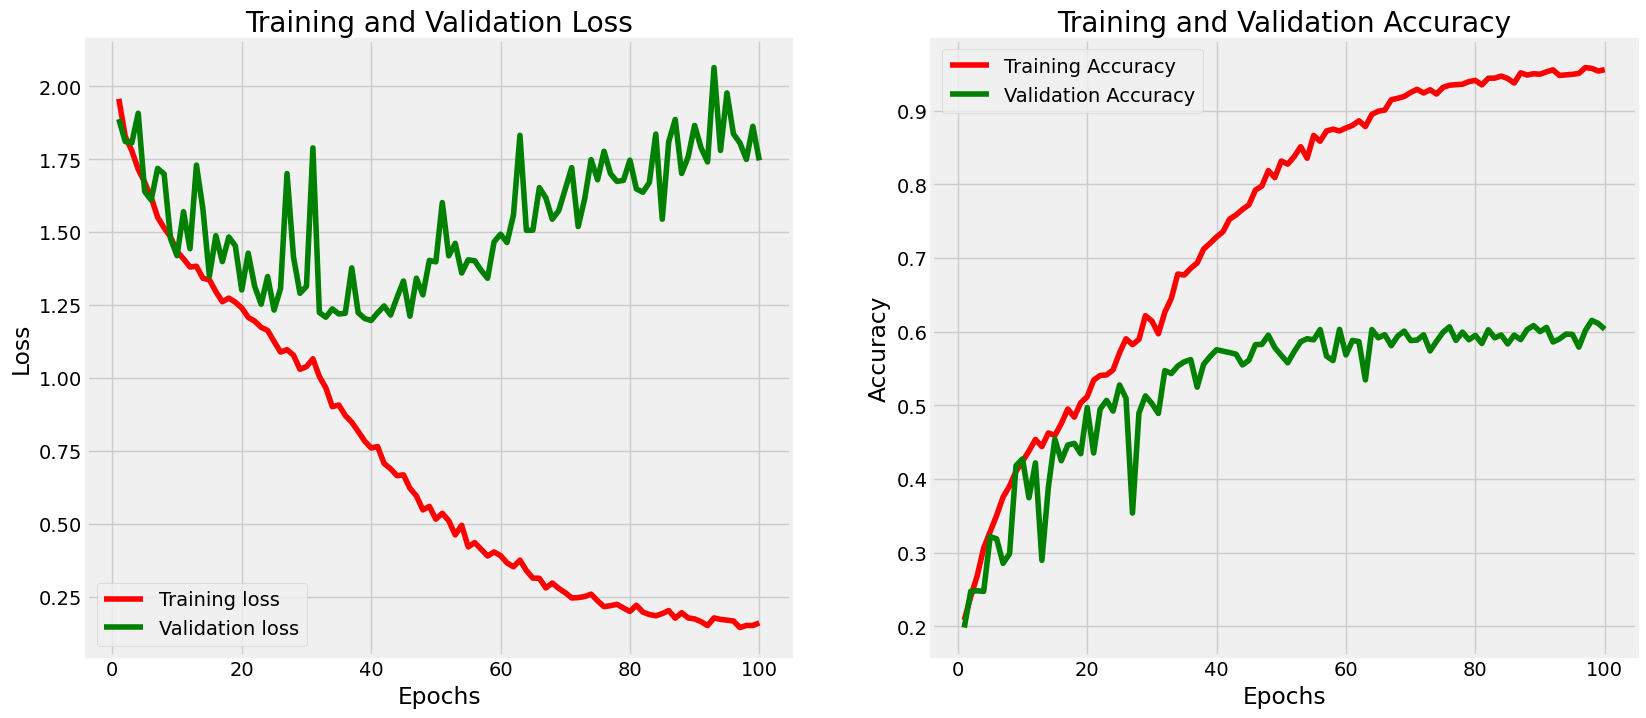

In [45]:
# Display model performance
model_performance(history, epochs)

In [43]:
cnn_gcn_model.save

<bound method Model.save of <Functional name=functional, built=True>>

In [53]:
# Evaluate the model
model_evaluation(cnn_gcn_model, train_generator, test_generator) 

897/897 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9597 - loss: 0.1245
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6889 - loss: 1.5186
Train Loss:  0.1287255883216858
Train Accuracy:  0.9605630040168762
--------------------
Test Loss:  1.7460252046585083
Test Accuracy:  0.6032366156578064


In [57]:
# Get predictions
y_pred = get_pred(cnn_gcn_model, test_generator)
y_pred


224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


array([1, 0, 1, ..., 3, 0, 5])

In [69]:
# Plot confusion matrix
plot_confusion_matrix(test_generator, y_pred, class_names)

AttributeError: 'DataGenerator' object has no attribute 'class_indices'

In [37]:
# Model evaluation
model_evaluation(cnn_gcn_model)

NameError: name 'train_gen' is not defined

In [39]:
# get predictions
y_pred = get_pred(cnn_gcn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

NameError: name 'cnn_model' is not defined

In [5]:
model_json = cnn_gcn_model.to_json()
with open("emotiondetector2_100epochs.json",'w') as json_file:
    json_file.write(model_json)
cnn_gcn_model.save("emotiondetector2_100epochs.keras")

NameError: name 'cnn_gcn_model' is not defined

In [3]:
from tensorflow.keras.models import model_from_json

# Load the JSON file
with open('emotiondetector2_100epochs.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Create the model from the JSON
loaded_model = model_from_json(loaded_model_json, custom_objects={'GraphConvLayer': GraphConvLayer})

re_cnn_gcn_model = loaded_model.load_weights('emotiondetector2_100epochs.keras')

NameError: name 'GraphConvLayer' is not defined

In [99]:
x_train, A_train, y_train, x_test, A_test, y_test, class_names = prepare_data('Data/train', 'Data/test')

disgust done
happy done
fear done
sad done
surprise done
neutral done
angry done
disgust done
happy done
fear done
sad done
surprise done
neutral done
angry done


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7178/7178 [00:52<00:00, 137.91it/s]


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

labels = class_names
le.fit(labels)
encoded_labels = le.transform(labels)
print(encoded_labels)

# Load the saved model
model = load_model('emotiondetector2_100epochs.keras', custom_objects={'GraphConvLayer': GraphConvLayer})

# Make predictions on the test set
y_pred = model.predict([x_test, A_test])

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from tensorflow.keras.models import load_model

model = load_model('emotiondetector2_100epochs.keras', custom_objects={'GraphConvLayer': GraphConvLayer})

import visualkeras
visualkeras.layered_view(model, to_file='output.png', legend=True, spacing=10)

NameError: name 'GraphConvLayer' is not defined